In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
from matplotlib import pyplot as plt

dataset=pd.read_csv('winequality-white.csv')
dataset_1=pd.read_csv('winequality-red.csv')
pd.options.mode.chained_assignment = None 

In [2]:
dataset['rating']='NaN'


In [3]:
dataset['Kind']='White'
dataset_1['Kind']='Red'
dataset=pd.concat([dataset,dataset_1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
dataset['rating'][dataset.quality<=4]=0  # Bad wine
dataset['rating'][dataset.quality>=7]=2 # Average Wine
dataset['rating'][(dataset.quality>=5) & (dataset.quality<=6)]=1  # Good Wine
dataset['rating'].astype(int)


0       1
1       1
2       1
3       1
4       1
       ..
1594    1
1595    1
1596    1
1597    1
1598    1
Name: rating, Length: 6497, dtype: int32

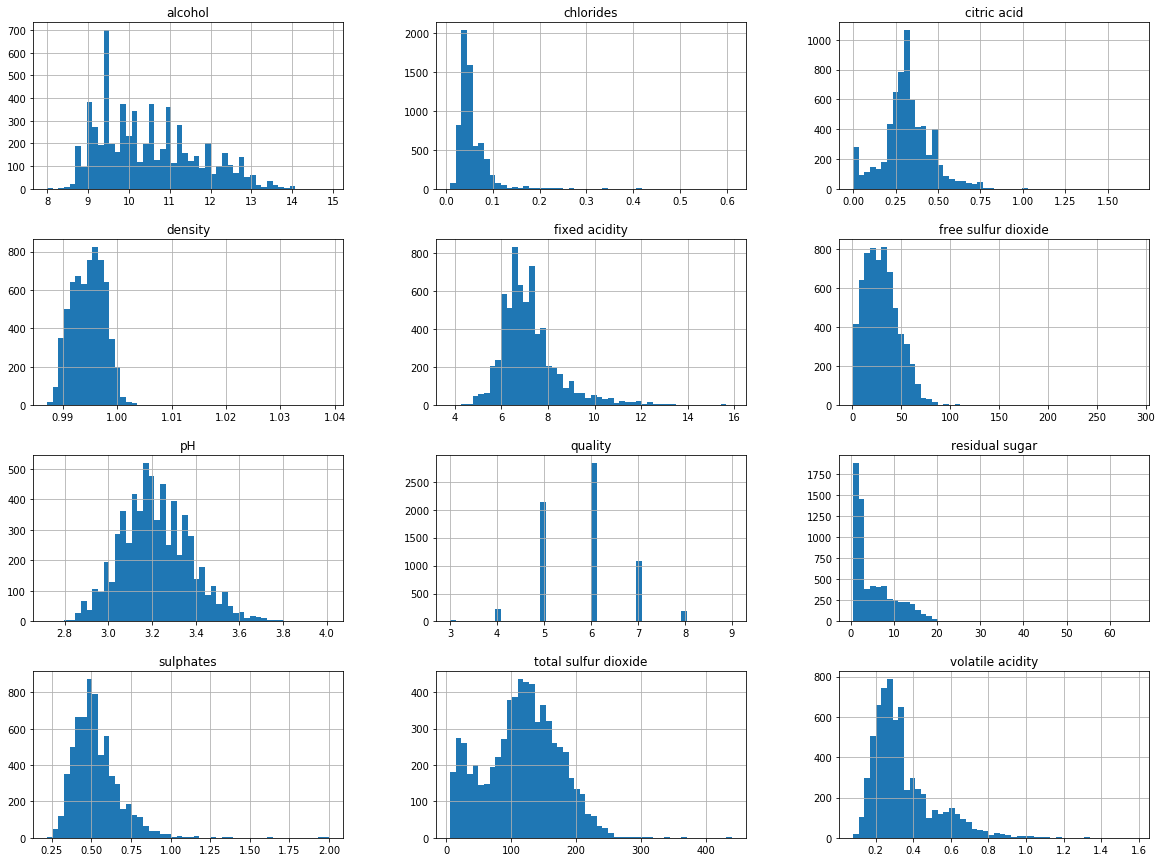

In [5]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
dataset.head()

,Kind,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,quality,rating,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,White,8.8,0.045,0.36,1.0010,7.0,45.0,3.00,6,1,20.7,0.45,170.0,0.27
1,White,9.5,0.049,0.34,0.9940,6.3,14.0,3.30,6,1,1.6,0.49,132.0,0.30
2,White,10.1,0.050,0.40,0.9951,8.1,30.0,3.26,6,1,6.9,0.44,97.0,0.28
3,White,9.9,0.058,0.32,0.9956,7.2,47.0,3.19,6,1,8.5,0.40,186.0,0.23
4,White,9.9,0.058,0.32,0.9956,7.2,47.0,3.19,6,1,8.5,0.40,186.0,0.23


In [7]:
dummies=pd.get_dummies(dataset['Kind'])
dataset=dataset.join(dummies)
dataset.drop(['Kind'], axis=1,inplace=True)
dataset=dataset[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','Red','White','quality','rating']]
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Red,White,quality,rating
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,1,6,1
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,0,6,1
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1,5,1
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,0,5,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,1,6,1


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, 1:13].values, dataset.rating.values, test_size = 0.2, random_state = 0)

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_train=y_train.astype('int')
y_test=y_test.astype('int')


In [10]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', max_depth=10,random_state = 0)
classifier.fit(X_train, y_train)



# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, y_pred)
print('******Test set confusion matrix************')
print(cm_test)




******Test set confusion matrix************
[[  25   49    1]
 [   2 1414   61]
 [   0  180  207]]


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [5, 10, 15,20], 'max_features': [1,2,3,4,5], 'max_depth':[5,10,15],'min_samples_split':[2,5,10],'min_samples_leaf':[1,5,10]},
    {'bootstrap': [False], 'n_estimators': [5, 10, 20], 'max_features': [1,2,3,4,5],'max_depth':[5,10,15],'min_samples_split':[2,5,10],'min_samples_leaf':[1,5,10]}
  ]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [18]:
print( grid_search.best_score_)
print(grid_search.best_params_)

0.9185146982980918
{'bootstrap': False, 'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [19]:
from sklearn.model_selection import cross_val_score
accuracies_train = cross_val_score(estimator = grid_search.best_estimator_, X = X_train, y = y_train, cv = 10)
accuracies_test = cross_val_score(estimator = grid_search.best_estimator_, X = X_test, y = y_test, cv = 10)
print('Training accuracy mean',accuracies_train.mean())
print('Training accuracy std',accuracies_train.std())
print('Testing accuracy mean',accuracies_test.mean())
print('Testing accuracy std',accuracies_test.std())

Training accuracy mean 0.9185177099745354
Training accuracy std 0.009357935324673623
Testing accuracy mean 0.82002065159926
Testing accuracy std 0.02334352476698939


In [10]:
import tensorflow as tf
from tensorflow import keras

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [17]:
model.compile( loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [18]:
X_valid=X_train[:1500]
y_valid=y_train[:1500]

In [19]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
history = model.fit(X_train, y_train, epochs=100,validation_data=(X_valid, y_valid)) 

Train on 7756 samples, validate on 1500 samples
Epoch 1/100
7756/7756 [==============================] - 1s 178us/sample - loss: 0.6892 - accuracy: 0.7523 - val_loss: 0.5883 - val_accuracy: 0.7680
Epoch 2/100
7756/7756 [==============================] - 1s 99us/sample - loss: 0.5687 - accuracy: 0.7818 - val_loss: 0.5462 - val_accuracy: 0.7927
Epoch 3/100
7756/7756 [==============================] - 1s 97us/sample - loss: 0.5448 - accuracy: 0.7913 - val_loss: 0.5234 - val_accuracy: 0.7953
Epoch 4/100
7756/7756 [==============================] - 1s 100us/sample - loss: 0.5317 - accuracy: 0.7927 - val_loss: 0.5104 - val_accuracy: 0.8040
Epoch 5/100
7756/7756 [==============================] - 1s 101us/sample - loss: 0.5230 - accuracy: 0.7967 - val_loss: 0.5016 - val_accuracy: 0.7967
Epoch 6/100
7756/7756 [==============================] - 1s 99us/sample - loss: 0.5159 - accuracy: 0.7977 - val_loss: 0.4945 - val_accuracy: 0.8053
Epoch 7/100
7756/7756 [==============================] - 1s 1

7756/7756 [==============================] - 1s 102us/sample - loss: 0.3854 - accuracy: 0.8404 - val_loss: 0.3543 - val_accuracy: 0.8553
Epoch 56/100
7756/7756 [==============================] - 1s 104us/sample - loss: 0.3832 - accuracy: 0.8415 - val_loss: 0.3549 - val_accuracy: 0.8533
Epoch 57/100
7756/7756 [==============================] - 1s 117us/sample - loss: 0.3829 - accuracy: 0.8413 - val_loss: 0.3642 - val_accuracy: 0.8493
Epoch 58/100
7756/7756 [==============================] - 1s 112us/sample - loss: 0.3811 - accuracy: 0.8445 - val_loss: 0.3836 - val_accuracy: 0.8353
Epoch 59/100
7756/7756 [==============================] - 1s 105us/sample - loss: 0.3791 - accuracy: 0.8444 - val_loss: 0.3467 - val_accuracy: 0.8627
Epoch 60/100
7756/7756 [==============================] - 1s 104us/sample - loss: 0.3765 - accuracy: 0.8431 - val_loss: 0.3537 - val_accuracy: 0.8580
Epoch 61/100
7756/7756 [==============================] - 1s 112us/sample - loss: 0.3754 - accuracy: 0.8450 - val

In [21]:
model.evaluate(X_test,y_test)

1939/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.5124179440530814, 0.8076328]